In [1]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import imageio # scipy.msc.imread is depreciated in scipy 1.0.0 used imageio.imread instead
import colorsys
import imghdr
import random

from PIL import Image, ImageDraw, ImageFont
import argparse

import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import imghdr
from IPython.display import Image
from PIL import Image

# from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
# from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body
import warnings
warnings.filterwarnings('ignore')



## Import the required libraries 

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input
from keras.utils.data_utils import GeneratorEnqueuer


import math, os

%matplotlib inline
import colorsys
import imghdr
import random
from keras import backend as K
from PIL import Image, ImageDraw, ImageFont
import argparse
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model,Model

Using TensorFlow backend.


In [2]:
def read_classes(classes_path):
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def read_anchors(anchors_path):
    with open(anchors_path) as f:
        anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        anchors = np.array(anchors).reshape(-1, 2)
    return anchors

def generate_colors(class_names):
    hsv_tuples = [(x / len(class_names), 1., 1.) for x in range(len(class_names))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))
    random.seed(10101)  # Fixed seed for consistent colors across runs.
    random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    random.seed(None)  # Reset seed to default.
    return colors

def scale_boxes(boxes, image_shape):
    """ Scales the predicted boxes in order to be drawable on the image"""
    height = image_shape[0]
    width = image_shape[1]
    image_dims = K.stack([height, width, height, width])
    image_dims = K.reshape(image_dims, [1, 4])
    boxes = boxes * image_dims
    return boxes

def preprocess_image(img_path, model_image_size):
    image_type = imghdr.what(img_path)
    image = Image.open(img_path)
    #image.save("output_box.png")
    resized_image = image.resize(tuple(reversed(model_image_size)), Image.BICUBIC)
    image_data = np.array(resized_image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)  # Add batch dimension.
    return image, image_data

def draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors):
    font = ImageFont.truetype(font='arial.ttf',size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    thickness = (image.size[0] + image.size[1]) // 300

    for i, c in reversed(list(enumerate(out_classes))):
        predicted_class = class_names[c]
        box = out_boxes[i]
        score = out_scores[i]

        label = '{} {:.2f}'.format(predicted_class, score)

        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)

        top, left, bottom, right = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
        print(label, (left, top), (right, bottom))

        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        # My kingdom for a good redistributable image drawing library.
        for i in range(thickness):
            draw.rectangle([left + i, top + i, right - i, bottom - i], outline=colors[c])
        draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)], fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw

In [3]:
def yolo_head(feats, anchors, num_classes):
    """Convert final layer features to bounding box parameters.

    Parameters
    ----------
    feats : tensor
        Final convolutional layer features.
    anchors : array-like
        Anchor box widths and heights.
    num_classes : int
        Number of target classes.

    Returns
    -------
    box_xy : tensor
        x, y box predictions adjusted by spatial location in conv layer.
    box_wh : tensor
        w, h box predictions adjusted by anchors and conv spatial resolution.
    box_conf : tensor
        Probability estimate for whether each box contains any object.
    box_class_pred : tensor
        Probability distribution estimate for each box over class labels.
    """
    num_anchors = len(anchors)
    # Reshape to batch, height, width, num_anchors, box_params.
    anchors_tensor = K.reshape(K.variable(anchors), [1, 1, 1, num_anchors, 2])
    # Static implementation for fixed models.
    # TODO: Remove or add option for static implementation.
    # _, conv_height, conv_width, _ = K.int_shape(feats)
    # conv_dims = K.variable([conv_width, conv_height])

    # Dynamic implementation of conv dims for fully convolutional model.
    conv_dims = K.shape(feats)[1:3]  # assuming channels last
    # In YOLO the height index is the inner most iteration.
    conv_height_index = K.arange(0, stop=conv_dims[0])
    conv_width_index = K.arange(0, stop=conv_dims[1])
    conv_height_index = K.tile(conv_height_index, [conv_dims[1]])

    # TODO: Repeat_elements and tf.split doesn't support dynamic splits.
    # conv_width_index = K.repeat_elements(conv_width_index, conv_dims[1], axis=0)
    conv_width_index = K.tile(K.expand_dims(conv_width_index, 0), [conv_dims[0], 1])
    conv_width_index = K.flatten(K.transpose(conv_width_index))
    conv_index = K.transpose(K.stack([conv_height_index, conv_width_index]))
    conv_index = K.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
    conv_index = K.cast(conv_index, K.dtype(feats))
    
    feats = K.reshape(feats, [-1, conv_dims[0], conv_dims[1], num_anchors, num_classes + 5])
    conv_dims = K.cast(K.reshape(conv_dims, [1, 1, 1, 1, 2]), K.dtype(feats))
    # Static generation of conv_index:
    # conv_index = np.array([_ for _ in np.ndindex(conv_width, conv_height)])
    # conv_index = conv_index[:, [1, 0]]  # swap columns for YOLO ordering.
    # conv_index = K.variable(
    #     conv_index.reshape(1, conv_height, conv_width, 1, 2))
    # feats = Reshape(
    #     (conv_dims[0], conv_dims[1], num_anchors, num_classes + 5))(feats)

    box_confidence = K.sigmoid(feats[..., 4:5])
    box_xy = K.sigmoid(feats[..., :2])
    box_wh = K.exp(feats[..., 2:4])
    box_class_probs = K.softmax(feats[..., 5:])

    # Adjust preditions to each spatial grid point and anchor size.
    # Note: YOLO iterates over height index before width index.
    box_xy = (box_xy + conv_index) / conv_dims
    box_wh = box_wh * anchors_tensor / conv_dims

    return box_confidence, box_xy, box_wh, box_class_probs




def yolo_boxes_to_corners(box_xy, box_wh):
    """Convert YOLO box predictions to bounding box corners."""
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return K.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2],  # y_max
        box_maxes[..., 0:1]  # x_max
    ])



def yolo_eval(yolo_outputs,
              image_shape,
              max_boxes=10,
              score_threshold=.6,
              iou_threshold=.5):
    """Evaluate YOLO model on given input batch and return filtered boxes."""
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    boxes, scores, classes = yolo_filter_boxes(
        box_confidence, boxes, box_class_probs, threshold=score_threshold)
    
    # Scale boxes back to original image shape.
    height = image_shape[0]
    width = image_shape[1]
    image_dims = K.stack([height, width, height, width])
    image_dims = K.reshape(image_dims, [1, 4])
    boxes = boxes * image_dims

    # TODO: Something must be done about this ugly hack!
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')
    K.get_session().run(tf.variables_initializer([max_boxes_tensor]))
    nms_index = tf.image.non_max_suppression(
        boxes, scores, max_boxes_tensor, iou_threshold=iou_threshold)
    boxes = K.gather(boxes, nms_index)
    scores = K.gather(scores, nms_index)
    classes = K.gather(classes, nms_index)
    
    return boxes, scores, classes

def preprocess_true_boxes(true_boxes, anchors, image_size):
    """Find detector in YOLO where ground truth box should appear.

    Parameters
    ----------
    true_boxes : array
        List of ground truth boxes in form of relative x, y, w, h, class.
        Relative coordinates are in the range [0, 1] indicating a percentage
        of the original image dimensions.
    anchors : array
        List of anchors in form of w, h.
        Anchors are assumed to be in the range [0, conv_size] where conv_size
        is the spatial dimension of the final convolutional features.
    image_size : array-like
        List of image dimensions in form of h, w in pixels.

    Returns
    -------
    detectors_mask : array
        0/1 mask for detectors in [conv_height, conv_width, num_anchors, 1]
        that should be compared with a matching ground truth box.
    matching_true_boxes: array
        Same shape as detectors_mask with the corresponding ground truth box
        adjusted for comparison with predicted parameters at training time.
    """
    height, width = image_size
    num_anchors = len(anchors)
    # Downsampling factor of 5x 2-stride max_pools == 32.
    # TODO: Remove hardcoding of downscaling calculations.
    assert height % 32 == 0, 'Image sizes in YOLO_v2 must be multiples of 32.'
    assert width % 32 == 0, 'Image sizes in YOLO_v2 must be multiples of 32.'
    conv_height = height // 32
    conv_width = width // 32
    num_box_params = true_boxes.shape[1]
    detectors_mask = np.zeros(
        (conv_height, conv_width, num_anchors, 1), dtype=np.float32)
    matching_true_boxes = np.zeros(
        (conv_height, conv_width, num_anchors, num_box_params),
        dtype=np.float32)
    for box in true_boxes:
        # scale box to convolutional feature spatial dimensions
        box_class = box[4:5]
        box = box[0:4] * np.array(
            [conv_width, conv_height, conv_width, conv_height])
        i = np.floor(box[1]).astype('int')
        j = min(np.floor(box[0]).astype('int'),1)
        best_iou = 0
        best_anchor = 0
                
        for k, anchor in enumerate(anchors):
            # Find IOU between box shifted to origin and anchor box.
            box_maxes = box[2:4] / 2.
            box_mins = -box_maxes
            anchor_maxes = (anchor / 2.)
            anchor_mins = -anchor_maxes

            intersect_mins = np.maximum(box_mins, anchor_mins)
            intersect_maxes = np.minimum(box_maxes, anchor_maxes)
            intersect_wh = np.maximum(intersect_maxes - intersect_mins, 0.)
            intersect_area = intersect_wh[0] * intersect_wh[1]
            box_area = box[2] * box[3]
            anchor_area = anchor[0] * anchor[1]
            iou = intersect_area / (box_area + anchor_area - intersect_area)
            if iou > best_iou:
                best_iou = iou
                best_anchor = k
                
        if best_iou > 0:
            detectors_mask[i, j, best_anchor] = 1
            adjusted_box = np.array(
                [
                    box[0] - j, box[1] - i,
                    np.log(box[2] / anchors[best_anchor][0]),
                    np.log(box[3] / anchors[best_anchor][1]), box_class
                ],
                dtype=np.float32)
            matching_true_boxes[i, j, best_anchor] = adjusted_box
    return detectors_mask, matching_true_boxes

### Defining yolo_filter_boxes

In [4]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold =0.8):
    #step1:compute the box scores
    box_scores=box_confidence*box_class_probs
    
    #step2: Find the box_classes using the max box_scores, keep track of the corresponding score
    box_classes=K.argmax(box_scores, axis=-1)
    box_class_scores=K.max(box_scores,axis=-1)
    # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
    # same dimension as box_class_scores, and be True for the boxes you want to keep (with probability >= threshold)
    filtering_mask= box_class_scores>= threshold
    
    # Step 4: Apply the mask to box_class_scores, boxes and box_classes
    
    scores=tf.boolean_mask(box_class_scores,filtering_mask)
    boxes=tf.boolean_mask(boxes,filtering_mask)
    classes=tf.boolean_mask(box_classes,filtering_mask)
    
    return scores, boxes, classes
    
    

#### Non-Max Supression

In [5]:
def iou(box1,box2):
    #Assign variable name to coordinates for claritty
    (box1_x1, box1_y1, box1_x2, box1_y2) = box1
    (box2_x1, box2_y1, box2_x2, box2_y2) = box2
     # Calculate the (yi1, xi1, yi2, xi2) coordinates of the intersection of box1 and box2. Calculate its Area.
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    inter_width = max(xi2-xi1, 0)
    inter_height = max(yi2-yi1, 0)
    inter_area = inter_height*inter_width
    
    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
     
    box1_area = (box1[3] - box1[1]) *  (box1[2] - box1[0])
    box2_area = (box2[3] - box2[1]) *  (box2[2] - box2[0])
    union_area = box1_area + box2_area - inter_area
    
    # compute the IoU

    iou = inter_area / union_area
    
    return iou
    
    

In [6]:
## Example

## Test case 1: boxes intersect
box1 = (2, 1, 4, 3)
box2 = (1, 2, 3, 4) 
print("iou for intersecting boxes = " + str(iou(box1, box2)))

## Test case 2: boxes do not intersect
box1 = (1,2,3,4)
box2 = (5,6,7,8)
print("iou for non-intersecting boxes = " + str(iou(box1,box2)))

## Test case 3: boxes intersect at vertices only
box1 = (1,1,2,2)
box2 = (2,2,3,3)
print("iou for boxes that only touch at vertices = " + str(iou(box1,box2)))

## Test case 4: boxes intersect at edge only
box1 = (1,1,3,3)
box2 = (2,3,3,4)
print("iou for boxes that only touch at edges = " + str(iou(box1,box2)))

iou for intersecting boxes = 0.14285714285714285
iou for non-intersecting boxes = 0.0
iou for boxes that only touch at vertices = 0.0
iou for boxes that only touch at edges = 0.0


In [7]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 3, iou_threshold = 0.7):
    
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) # initialize variable max_boxes_tensor
    
    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    ### START CODE HERE ### (≈ 1 line)
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes, iou_threshold)
    ### END CODE HERE ###
    
    # Use K.gather() to select only nms_indices from scores, boxes and classes
    ### START CODE HERE ### (≈ 3 lines)
    scores = K.gather(scores, nms_indices)
    boxes = K.gather(boxes, nms_indices)
    classes = K.gather(classes, nms_indices)
    ### END CODE HERE ###
    
    return scores, boxes, classes
    

In [8]:
# GRADED FUNCTION: yolo_eval

def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """
    
    ### START CODE HERE ### 
    
    # Retrieve outputs of the YOLO model (≈1 line)
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs

    # Convert boxes to be ready for filtering functions (convert boxes box_xy and box_wh to corner coordinates)
    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold (≈1 line)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, score_threshold)
    
    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)

    # Use one of the functions you've implemented to perform Non-max suppression with 
    # maximum number of boxes set to max_boxes and a threshold of iou_threshold (≈1 line)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)
    
    ### END CODE HERE ###
    
    return scores, boxes, classes

### Summary for YOLO:

1.Input image (608, 608, 3)

2.The input image goes through a CNN, resulting in a (19,19,5,85) dimensional output.

3.After flattening the last two dimensions, the output is a volume of shape (19, 19, 425):

 .Each cell in a 19x19 grid over the input image gives 425 numbers.
 
 .425 = 5 x 85 because each cell contains predictions for 5 boxes, corresponding to 5 anchor boxes, as seen in lecture.
 
 .85 = 5 + 80 where 5 is because  (pc,bx,by,bh,bw)(pc,bx,by,bh,bw)  has 5 numbers, and 80 is the number of classes we'd like to detect

4.You then select only few boxes based on:
Score-thresholding: throw away boxes that have detected a class with a score less than the threshold
Non-max suppression: Compute the Intersection over Union and avoid selecting overlapping boxes

5.This gives you YOLO's final output.

#### Test YOLO pre-trained model on images
In this part, you are going to use a pre-trained model and test it on the dataset. We'll need a session to execute the computation graph and evaluate the tensors.

In [9]:
sess = K.get_session()

#### Defining classes, anchors and image shape.

Recall that we are trying to detect 80 classes, and are using 5 anchor boxes.

We have gathered the information on the 80 classes and 5 boxes in two files "coco_classes.txt" and "yolo_anchors.txt".

We'll read class names and anchors from text files.

The car detection dataset has 720x1280 images, which we've pre-processed into 608x608 images.

In [55]:
class_names = read_classes("coco_classes.txt")
anchors = read_anchors("yolo_anchors.txt")
image_shape = (720.,720.) 

#### Loading a pre-trained model
Training a YOLO model takes a very long time and requires a fairly large dataset of labelled bounding boxes for a large range of target classes.

You are going to load an existing pre-trained Keras YOLO model stored in "yolo.h5".

These weights come from the official YOLO website, and were converted using a function written by Allan Zelener. References are at the end of this notebook. Technically, these are the parameters from the "YOLOv2" model, but we will simply refer to it as "YOLO" in this notebook.

In [11]:
yolo_model = load_model("yolo.h5")

In [12]:
yolo_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

###  Convert output of the model to usable bounding box tensors

The output of `yolo_model` is a (m, 19, 19, 5, 85) tensor that needs to pass through non-trivial processing and conversion.


In [56]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

### Filtering boxes
yolo_outputs gave you all the predicted boxes of yolo_model in the correct format. You're now ready to perform filtering and select only the best boxes. Let's now call yolo_eval, which you had previously implemented, to do this.

In [57]:

scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

#### Run the graph on an image
Let the fun begin. You have created a graph that can be summarized as follows:

yolo_model.input is given to yolo_model. The model is used to compute the output yolo_model.output
yolo_model.output is processed by yolo_head. It gives you yolo_outputs
yolo_outputs goes through a filtering function, yolo_eval. It outputs your predictions: scores, boxes, classes

Implement predict() which runs the graph to test YOLO on an image. You will need to run a TensorFlow session, to have it compute scores, boxes, classes.

In [58]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc

def predict(sess, image_file):
    """
    Runs the graph stored in "sess" to predict boxes for "image_file". Prints and plots the preditions.
    
     Arguments:
    sess -- your tensorflow/Keras session containing the YOLO graph
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """

    # Preprocess your image
    image, image_data = preprocess_image(image_file, model_image_size = (608, 608))
    #image, image_data = preprocess_image(image_file, model_image_size = (416, 416))
    print("input image:",image_data.shape)
    # Run the session with the correct tensors and choose the correct placeholders in the feed_dict.
    # You'll need to use feed_dict={yolo_model.input: ... , K.learning_phase(): 0})
    ### START CODE HERE ### (≈ 1 line)
    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes], feed_dict={yolo_model.input:image_data,K.learning_phase(): 0})
    ### END CODE HERE ###
    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    if len(out_boxes) == 0:
        return out_scores, out_boxes, out_classes
    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    # Draw bounding boxes on the image file
    print('Drawing images...')
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    print('Drawing complete...')
    # Save the predicted bounding box on the image
    #image.save(os.path.join("out", image_file), quality=90)
    image.save("output_image1.jpg", quality=90)
    # Display the results in the notebook
    output_image = imageio.imread("output_image1.jpg")
    #imshow(output_image)
    plt.figure(figsize=(10,8))
    plt.imshow(plt.imread("output_image1.jpg"))
    plt.show()
    return out_scores, out_boxes, out_classes

In [59]:
image_file = "bike1.jpg"
print(yolo_model.input)
print(yolo_model.output)

Tensor("input_1:0", shape=(?, 608, 608, 3), dtype=float32)
Tensor("conv2d_23/BiasAdd:0", shape=(?, 19, 19, 425), dtype=float32)


input image: (1, 608, 608, 3)
Found 2 boxes for bike1.jpg
Drawing images...
person 0.66 (123, 104) (429, 629)
motorbike 0.80 (47, 183) (720, 694)
Drawing complete...


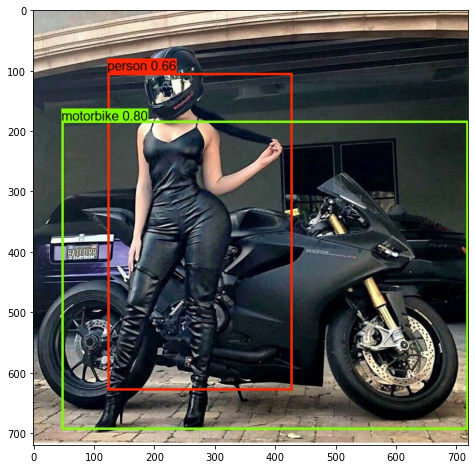

In [60]:
out_scores, out_boxes, out_classes = predict(sess,image_file)

#### Second Example

In [76]:
image_shape = (1700.,1500.) 
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc


def predict(sess, image_file):
    """
    Runs the graph stored in "sess" to predict boxes for "image_file". Prints and plots the preditions.
    
     Arguments:
    sess -- your tensorflow/Keras session containing the YOLO graph
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """

    # Preprocess your image
    image, image_data = preprocess_image(image_file, model_image_size = (608, 608))
    #image, image_data = preprocess_image(image_file, model_image_size = (416, 416))
    print("input image:",image_data.shape)
    # Run the session with the correct tensors and choose the correct placeholders in the feed_dict.
    # You'll need to use feed_dict={yolo_model.input: ... , K.learning_phase(): 0})
    ### START CODE HERE ### (≈ 1 line)
    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes], feed_dict={yolo_model.input:image_data,K.learning_phase(): 0})
    ### END CODE HERE ###
    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    if len(out_boxes) == 0:
        return out_scores, out_boxes, out_classes
    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    # Draw bounding boxes on the image file
    print('Drawing images...')
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    print('Drawing complete...')
    # Save the predicted bounding box on the image
    #image.save(os.path.join("out", image_file), quality=90)
    image.save("output_image1.jpg", quality=90)
    # Display the results in the notebook
    output_image = imageio.imread("output_image1.jpg")
    #imshow(output_image)
    plt.figure(figsize=(10,8))
    plt.imshow(plt.imread("output_image1.jpg"))
    plt.show()
    return out_scores, out_boxes, out_classes


In [77]:
image_file = "beautiful-biker.jpg"
print(yolo_model.input)
print(yolo_model.output)

Tensor("input_1:0", shape=(?, 608, 608, 3), dtype=float32)
Tensor("conv2d_23/BiasAdd:0", shape=(?, 19, 19, 425), dtype=float32)


input image: (1, 608, 608, 3)
Found 2 boxes for beautiful-biker.jpg
Drawing images...
motorbike 0.85 (337, 455) (1333, 1156)
person 0.89 (389, 69) (941, 1156)
Drawing complete...


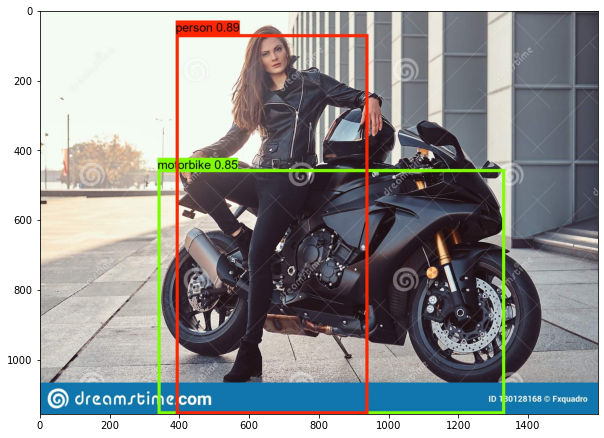

In [78]:
out_scores, out_boxes, out_classes = predict(sess,image_file)

In [1]:
# image_shape = (2448.,3264.) 
# scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)
# import matplotlib.pyplot as plt
# from matplotlib.pyplot import imshow
# import scipy.io
# import scipy.misc


# def predict(sess, image_file):
#     """
#     Runs the graph stored in "sess" to predict boxes for "image_file". Prints and plots the preditions.
    
#      Arguments:
#     sess -- your tensorflow/Keras session containing the YOLO graph
#     image_file -- name of an image stored in the "images" folder.
    
#     Returns:
#     out_scores -- tensor of shape (None, ), scores of the predicted boxes
#     out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
#     out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
#     Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
#     """

#     # Preprocess your image
#     image, image_data = preprocess_image(image_file, model_image_size = (608, 608))
#     #image, image_data = preprocess_image(image_file, model_image_size = (416, 416))
#     print("input image:",image_data.shape)
#     # Run the session with the correct tensors and choose the correct placeholders in the feed_dict.
#     # You'll need to use feed_dict={yolo_model.input: ... , K.learning_phase(): 0})
#     ### START CODE HERE ### (≈ 1 line)
#     out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes], feed_dict={yolo_model.input:image_data,K.learning_phase(): 0})
#     ### END CODE HERE ###
#     # Print predictions info
#     print('Found {} boxes for {}'.format(len(out_boxes), image_file))
#     if len(out_boxes) == 0:
#         return out_scores, out_boxes, out_classes
#     # Generate colors for drawing bounding boxes.
#     colors = generate_colors(class_names)
#     # Draw bounding boxes on the image file
#     print('Drawing images...')
#     draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
#     print('Drawing complete...')
#     # Save the predicted bounding box on the image
#     #image.save(os.path.join("out", image_file), quality=90)
#     image.save("output_image1.jpg", quality=90)
#     # Display the results in the notebook
#     output_image = imageio.imread("output_image1.jpg")
#     #imshow(output_image)
#     plt.figure(figsize=(10,8))
#     plt.imshow(plt.imread("output_image1.jpg"))
#     plt.show()
#     return out_scores, out_boxes, out_classes

# image_file = "fun.jpg"
# print(yolo_model.input)
# print(yolo_model.output)
# out_scores, out_boxes, out_classes = predict(sess,image_file)

In [71]:
scipy.__version__

'1.4.1'

In [72]:
# PIL.Image.open("majestic creature.jpeg").convert("RGB")